In [5]:
%pylab inline
import galsim
import numpy as np
import astropy.io.fits as pyfits
import fpfsBase
import imgutil

Populating the interactive namespace from numpy and matplotlib


In [6]:
cd wrkDir/FPFS2/sim

[Errno 2] No such file or directory: 'wrkDir/FPFS2/sim'
/home/xiangchong/work/gw_ipmu/work/FPFS2/sim


+ correlation of shape modes

In [7]:
# Get the  galaxy generator      
# Load data
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   '../../galsim_train/COSMOS_25.2_training_sample/'
cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)

In [4]:
# PSF preparation
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   1
nx          =   1
ny          =   1000
ndata       =   nx*ny
scale       =   0.168
ngridTot    =   ngrid*nx
flux_scaling=   2.587

bigfft      =   galsim.GSParams(maximum_fft_size=10240)
# index
ifield=1
index_use   =   cosmos_cat.orig_index
# parametric catalog
param_cat   =   cosmos_cat.param_cat[index_use]
index       =   ifield%81400
record      =   param_cat[index]
# prepare the galaxies
gal0        =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
gal0        *=  flux_scaling

In [5]:
# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
psfImg      =   galsim.fits.read(psfFname)
noiseHead   =   pyfits.getheader(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
# Get the shear information
g1          =   noiseHead['g1']
g2          =   noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
#variance    =   noiseHead['var']
variance    =   noiseHead['var']/15.
rescale     =   noiseHead['rescale']
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)
final     =   galsim.Convolve([psfInt,gal0],gsparams=bigfft)

In [6]:
# setup the galaxy image and the noise image
gal_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image.setOrigin(0,0)
data_rows   =   []

for i in range(ny):
    # Prepare the subimage
    ix      =   0
    iy      =   i
    b       =   galsim.BoundsI(ix*ngrid, (ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_gal_image = gal_image[b]
    # Draw the galaxy image
    final.drawImage(sub_gal_image,method='no_pixel')

In [7]:
# Noise
corPre='corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
corNoise    =   galsim.getCOSMOSNoise(file_name=corFname,rng=ud,cosmos_scale=scale,variance=variance)
corNoise.applyTo(gal_image)

galsim.Image(bounds=galsim.BoundsI(xmin=0, xmax=63, ymin=0, ymax=63999), array=
array([[-0.00066272,  0.04257766,  0.01411302, ...,  0.00924567,
         0.01159567,  0.02008811],
       [-0.00752158, -0.01744253, -0.00639498, ...,  0.00119745,
         0.02695277,  0.01925791],
       [ 0.02199348, -0.0155153 , -0.01080008, ...,  0.00719848,
        -0.00570962,  0.00628137],
       ...,
       [-0.004092  , -0.02913594,  0.0168175 , ..., -0.00216825,
        -0.00400859, -0.02435887],
       [-0.00468478,  0.00793379,  0.0067194 , ..., -0.00875479,
         0.03233561, -0.00771736],
       [-0.01187223, -0.02314564, -0.02091939, ..., -0.00201329,
        -0.02516785, -0.00181444]], dtype=float32), wcs=galsim.OffsetWCS(0.168, galsim.PositionI(x=-1, y=-1), galsim.PositionD(x=0.0, y=0.0)))

(1000, 64, 64)


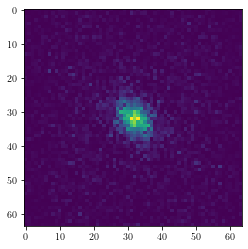

In [8]:
image_list=np.stack(np.vsplit(gal_image.array,1000))
print(image_list.shape)
galPow=imgutil.getFouPow(image_list[0])
subPow=imgutil.fitNoiPow(ngrid,galPow,np.ones((1,ngrid,ngrid)),26)
imshow(galPow-subPow)

In [9]:
psfData=np.pad(psfImg.array,(11,10))
print(psfData.shape)
fpTask=fpfsBase.fpfsTask(psfData,np.ones((1,ngrid,ngrid)))

(64, 64)


In [16]:
moments=fpTask.measure(image_list)
e12=fpfsBase.fpfsM2E(moments,const=1000)

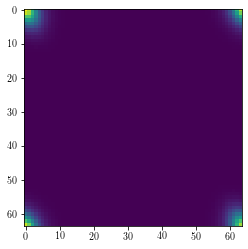

In [12]:
gal_array=gal_image.array
galPMea=np.abs(np.fft.fft2(gal_array))**2.
plt.imshow(galPMea)

In [13]:
# Estimate Power spectrum
noiPMea=np.zeros((ngrid,ngrid))
num=0
for i in range(8000):
    noi_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
    corNoise.applyTo(noi_image)
    noi_array=noi_image.array
    noiPMea+=np.abs(np.fft.fft2(noi_array))**2.
    num+=1
# make sure the <n(k)n(k)>=0
noiPMea=noiPMea/num
print(np.average(noiPMea))

0.923173704806413


-0.0004335477616027871


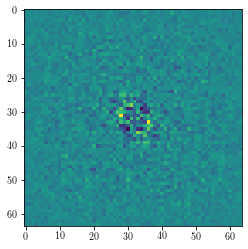

In [14]:
# residual
ngPMea=np.zeros((ngrid,ngrid))
num=0
for i in range(10000):
    ng_image=gal_image.copy()
    corNoise.applyTo(ng_image)
    ng_array=ng_image.array
    ngPMea+=np.abs(np.fft.fft2(ng_array))**2.
    num+=1
# make sure the <n(k)n(k)>=0
resPMea=ngPMea/num-galPMea-noiPMea
print(np.average(resPMea))
plt.imshow(np.fft.fftshift(resPMea))

In [15]:
# variance of residuals
res2PMea=np.zeros((ngrid,ngrid))
num=0
for i in range(10000):
    ng_image=gal_image.copy()
    corNoise.applyTo(ng_image)
    ng_array=ng_image.array
    res2PMea+=(np.abs(np.fft.fft2(ng_array))**2.-galPMea-noiPMea)**2.
    num+=1

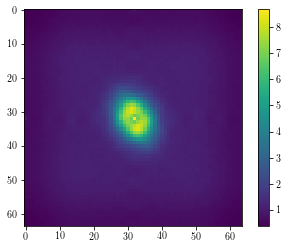

In [23]:
resStd=res2PMea/num
resStd=np.sqrt(resStd)
plt.imshow(fft.fftshift(resStd))
plt.colorbar()

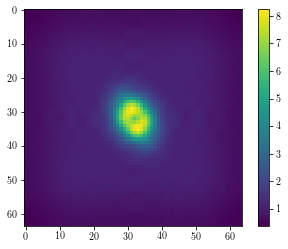

In [22]:
predict=2*galPMea*noiPMea+noiPMea**2.
plt.imshow(fft.fftshift(np.sqrt(predict)))
plt.colorbar()

-0.00039536607960477543


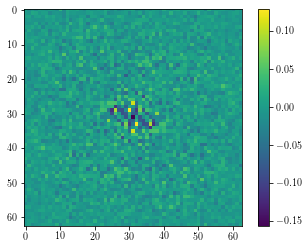

In [35]:
out=resStd-np.sqrt(predict)
out[0,0]-=(np.sqrt(2.)-1)*np.sqrt(predict[0,0])
plt.imshow(np.fft.fftshift(out)[1:,1:])
print(np.average(out))
plt.colorbar()

In [32]:
print(out[0,0])

-0.15692730523204812
